# How much money do we make with a small edge?
## Fixed wager strategy

*NB:*
- *This betting strategy is importantly different than strategies that use compounding or dynamically bet based on their current bankroll such as the Kelly Criterion which does both*
- *In the notebook, **bets** and **plays** are synonymous*

A Vegas coinflip costs -110 which is a break even probability of $52.4\%$ or decimal odds of $1.91$. The purpose of this simulation is to get a sense for how big of a margin we should use when placing bets **using a fixed betting strategy (you will always wager the same amount.)** For example if Vegas believes is 50/50, they'll offer -110 on both sides: a 50% *implied probability*. However in reality we want to make money, we will have to do better than the *break even probability* that adds another $2\% - 2.5\%$ on average, in this case $2.4\%$. 

Let's say our model is truly better than Vegas at determining the probability of a loaded coin flip and that probability is fixed. Specifically, Vegas is offering $1.91$ odds because they believe their game/event to have a true probability of 50%. This means we would need to be right $52.4\%$ of the time to finish to break even in the long run. Again, this is our break even probability. However our model knows its truly $55\%$. This gives us around $2.6\%$ edge. 

In order to understand how much money we make given this edge, we will use simulation to determine:<br><br>
**How many times would we have to play the game in order to double our money?**

In [1]:
from scipy import stats as st
from numpy import random as rand
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')

In [2]:
N = int(1e6)
p = 0.55

rng = rand.default_rng(seed=69)
draws = st.bernoulli.rvs(p, size=N, random_state=rng)

A common rule is that betting 1% of your capital is conservative whereas 5% is aggressive so we will use this range for our wagers. 

In [3]:
bank_start = 1000
payout_decimal = 1.91  # 52.4% breakeven probability

plays = [int(x) for x in [1e1, 1e2, 1e3, 1e4, 1e5, 1e6]]
bet_pcts = [0.01, 0.02, 0.03, 0.04, 0.05]

res = []

for bp in bet_pcts:
    for pl in plays:
        i = 0
        stop = False
        r = {}
        bank = bank_start
        wager = bank * bp
        for d in draws[:pl]:
            if d == 1:
                bank += wager * payout_decimal
            if not stop and bank < bank_start * 2:
                i+=1
            else:
                r['plays_to_double'] = i
                stop = True
        r['end_bank'] = bank
        r['num_plays'] = p
        r['wager'] = wager
        r['decimal_odds'] = payout_decimal
        r['wager pct'] = bp
        res.append(r)

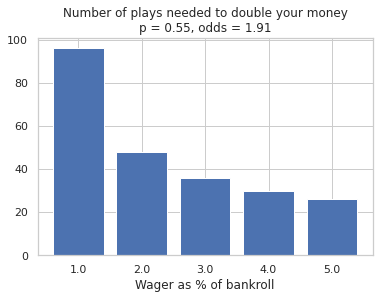

In [4]:
plt.bar([str(x['wager pct']*100) for x in res[5::6]], [x['plays_to_double'] for x in res[5::6]])
plt.title('Number of plays needed to double your money\np = {}, odds = {}'.format(p, payout_decimal))
plt.xlabel('Wager as % of bankroll')
plt.show()

This preliminary analysis pins it at around 100 plays for betting 1% of your bankroll. However this is only one path. Let's simulate more draws to better understand the distribution.

Let's gather data `i` on how long it takes to double our money using simulation. We will run `sims` simulations and each simulation will play the "game" (ie. flip the coin) `plays` times. We'll use at least `1e4` plays to ensure we double our money in (probably) every simulation.

In [5]:
sims = int(1e3)
plays = int(1e4)
p = 0.55

draws = st.bernoulli.rvs(p, size=(sims, plays), random_state=rng)

In [6]:
bank_start = 1000
payout_decimal = 1.91  # 52.4% breakeven probability

bet_pcts = [0.01, 0.02, 0.03, 0.04, 0.05]

res = []

for bp in bet_pcts:
    ptd = []
    for dr in draws:  # dr is a simulation
        i = 0
        bank = bank_start
        wager = bank * bp
        for d in dr:  # d is a play within the simulation
            bank -= wager  # fixed wager every time
            if d == 1:
                bank += wager * payout_decimal
            i+=1
            if bank >= bank_start * 2:
                ptd.append(i)  # i is your sample statistic
                break
    r = {}
    r['wager pct'] = bp
    r['data'] = ptd
    res.append(r)

Compute sample statistics on our simulated data.

In [7]:
for i in range(len(res)):
    data = np.array(res[i]['data'])
    res[i]['ci_99_low'] = np.quantile(data, 0.005)
    res[i]['ci_99_high'] = np.quantile(data, 0.995)
    res[i]['mean'] = np.round(data.mean())
    res[i]['median'] = np.round(np.median(data))
    # given our sample statistic is NOT an average, we will not divide by sqrt(n)
    res[i]['std'] = np.round(data.std(ddof=1))  # given 1k samples, n-1 df is probably trivial

In [8]:
chart_df = pd.DataFrame(res).explode('data').reset_index(drop=True)
chart_df['wager pct'] = (chart_df['wager pct'] * 100).astype('int').astype('object')
chart_df['data'] = chart_df['data'].astype('float')
# seaborn doesn't remove outliers
chart_df = chart_df.loc[(chart_df['data'] >= chart_df['ci_99_low']) & (chart_df['data'] <= chart_df['ci_99_high'])]

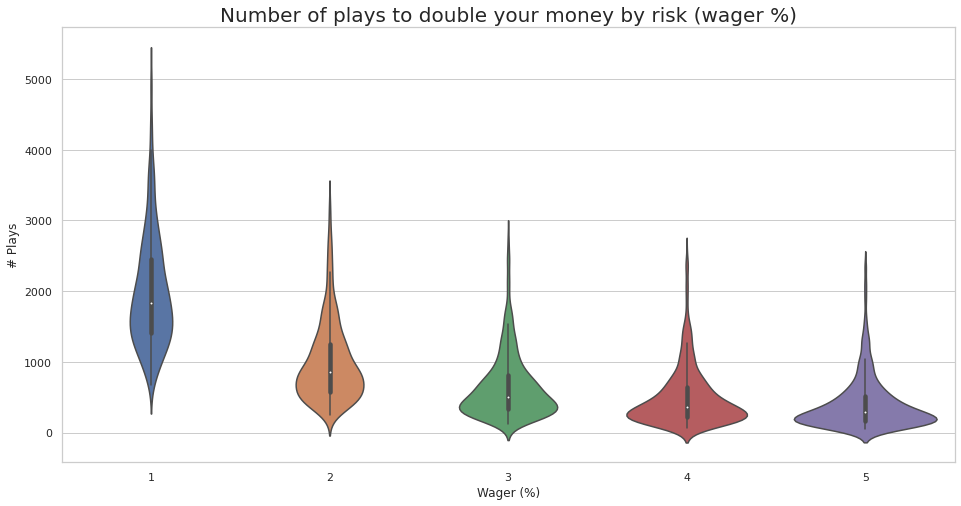

In [9]:
fig, ax = plt.subplots(figsize=(16,8))
ax = sns.violinplot(x='wager pct', y='data', data=chart_df, inner='box')
plt.xlabel('Wager (%)')
plt.ylabel('# Plays')
plt.title('Number of plays to double your money by risk (wager %)', fontsize=20)
plt.show()

Note the violin plots use kernel density estimators based on the data and the underlying smoothing allows it to naively go below zero. This is fine given we are using this for visualization. We cannot have fewer than 1 play. 

Let's add a bit more raw data to help summarize these plots. 

In [10]:
dfs = []
hold = pd.DataFrame(res).explode('data').reset_index(drop=True)[['wager pct', 'data']].pivot(columns='wager pct', values='data')
for bp in bet_pcts:
    dfs.append(hold[bp].dropna().reset_index(drop=True).astype('int'))
stats = pd.concat(dfs,axis=1)
stats.describe([0.005, 0.025, .25, .5, .75, .975, .995])

,0.01,0.02,0.03,0.04,0.05
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2004.730000,1013.850000,660.753000,511.052000,416.956000
std,842.546697,599.749438,483.379799,440.014809,402.180381
min,587.000000,139.000000,75.000000,57.000000,41.000000
0.5%,668.925000,243.980000,123.000000,68.000000,49.980000
2.5%,829.800000,308.800000,164.900000,99.000000,64.000000
25%,1412.000000,582.000000,333.000000,225.000000,165.000000
50%,1839.000000,853.000000,510.000000,367.000000,286.000000
75%,2459.500000,1264.000000,822.500000,651.000000,524.000000
97.5%,3996.050000,2639.225000,2010.525000,1676.200000,1500.050000


# Conclusion
- If using the above fixed wager strategy, a rough heuristic is that we will need to ensure we can beat around 500 games per year!
  - Or we will need to find a bigger edge!
- Even with aggressive wagering, it's a pretty wide range (63 to 1499 at 95% CI) to ascertain when you'd double your money. Given that our NFL data had us placing closer to 50 wagers or so on average, we will likely need to 
  - take more risk or
  - find a way more bets (ie. betting on NBA, NHL, or MLB games)
- Even with a 5% edge, it could over 2k turns!
- We haven't look at draw down!

## Using a stronger edge
Let's use a 10% edge versus Vegas, $62.5\%$. We will compile this into a function that can be used for other parameterizations as well.

In [11]:
def run_sim(p, payout_decimal=1.91, bank_start=1000, sims=int(1e3), plays=int(1e4), bet_pcts=np.arange(0.01, 0.06, 0.01),
           rand_rng_seed=69):
    # config & prime
    sims = sims
    plays = plays
    p = p
    bank_start = bank_start
    payout_decimal = payout_decimal  # 1.91 is 52.4% breakeven probability
    bet_pcts = bet_pcts
    rng = rand.default_rng(seed=rand_rng_seed)
    
    # run simulation
    res = []
    draws = st.bernoulli.rvs(p, size=(sims, plays), random_state=rng)
    for bp in bet_pcts:
        ptd = []
        for dr in draws:
            i = 0
            bank = bank_start
            wager = bank * bp
            for d in dr:  # d is a play within the simulation
                bank -= wager  # fixed wager every time
                if d == 1:
                    bank += wager * payout_decimal
                i+=1
                if bank >= bank_start * 2:
                    ptd.append(i)  # i is your sample statistic
                    break
        r = {}
        r['wager pct'] = bp
        r['data'] = ptd
        res.append(r)
        
    # compute sample statistics on our simulated data
    for i in range(len(res)):
        data = np.array(res[i]['data'])
        res[i]['ci_99_low'] = np.quantile(data, 0.005)
        res[i]['ci_99_high'] = np.quantile(data, 0.995)
        res[i]['mean'] = np.round(data.mean())
        res[i]['median'] = np.round(np.median(data))
        # given our sample statistic is NOT an average, we will not divide by sqrt(n)
        res[i]['std'] = np.round(data.std(ddof=1))  # given 1k samples, n-1 df is probably trivial
        
    return res

def analyze_data(res):
    chart_df = pd.DataFrame(res).explode('data').reset_index(drop=True)
    chart_df['wager pct'] = (chart_df['wager pct'] * 100).astype('int').astype('object')
    chart_df['data'] = chart_df['data'].astype('float')
    # seaborn doesn't remove outliers
    chart_df = chart_df.loc[(chart_df['data'] >= chart_df['ci_99_low']) & (chart_df['data'] <= chart_df['ci_99_high'])]
    
    fig, ax = plt.subplots(figsize=(16,8))
    ax = sns.violinplot(x='wager pct', y='data', data=chart_df, inner='box')
    plt.xlabel('Wager (%)')
    plt.ylabel('# Plays')
    plt.title('Number of plays to double your money by risk (wager %)', fontsize=20)
    plt.show()
    
    dfs = []
    hold = pd.DataFrame(res).explode('data').reset_index(drop=True)[['wager pct', 'data']].pivot(columns='wager pct', values='data')
    bet_pcts = [x['wager pct'] for x in res]
    for bp in bet_pcts:
        dfs.append(hold[bp].dropna().reset_index(drop=True).astype('int'))
    stats = pd.concat(dfs,axis=1)
    summary = stats.describe([0.005, 0.025, .25, .5, .75, .975, .995])
    return summary

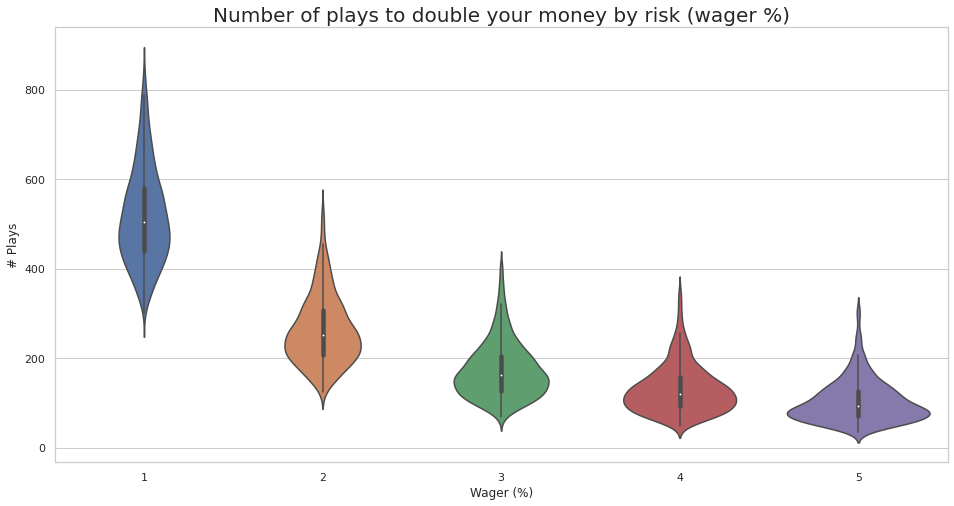

,0.01,0.02,0.03,0.04,0.05
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,518.256000,262.839000,174.407000,132.174000,104.122000
std,110.734125,79.627707,65.392167,57.741248,49.664834
min,278.000000,104.000000,60.000000,43.000000,31.000000
0.5%,300.950000,124.990000,68.990000,48.990000,34.990000
2.5%,342.950000,143.925000,84.950000,57.000000,41.000000
25%,438.000000,206.250000,127.000000,92.500000,71.000000
50%,505.000000,251.000000,161.000000,120.000000,92.000000
75%,583.000000,307.000000,205.500000,158.000000,127.000000
97.5%,774.050000,452.050000,339.000000,276.150000,232.050000


In [12]:
res = run_sim(0.625)
analyze_data(res)

When the edge is 10%, the number of bets we need to make moves towards the lower hundreds though NFL betting, is still probably a small sample size.